In [34]:
# Import
import numpy as np
import torch
import scipy.io
from matplotlib import pyplot as plt
import time
import torcwa
import Materials

# Hardware
# If GPU support TF32 tensor core, the matmul operation is faster than FP32 but with less precision.
# If you need accurate operation, you have to disable the flag below.
torch.backends.cuda.matmul.allow_tf32 = False
sim_dtype = torch.complex64
geo_dtype = torch.float32
device = torch.device('cuda')

# Simulation environment
# light
lamb0 = torch.tensor(940.,dtype=geo_dtype,device=device)    # nm
inc_ang = 0.*(np.pi/180)    # radian
azi_ang = 0.*(np.pi/180)    # radian

# material
substrate_eps = 1.46**2
silicon_eps = Materials.aSiH.apply(lamb0)**2

# geometry
L = [1880., 1880.]            # nm / nm
torcwa.rcwa_geo.dtype = geo_dtype
torcwa.rcwa_geo.device = device
torcwa.rcwa_geo.Lx = L[0]
torcwa.rcwa_geo.Ly = L[1]
torcwa.rcwa_geo.nx = 940
torcwa.rcwa_geo.ny = 940
torcwa.rcwa_geo.grid()
torcwa.rcwa_geo.edge_sharpness = 1000. #????

x_axis = torcwa.rcwa_geo.x.cpu()
y_axis = torcwa.rcwa_geo.y.cpu()

# layers
layer0_thickness = 235.

In [35]:
# Objective function
def objective_function(rho):
    order = [11,11]

    sim = torcwa.rcwa(freq=1/lamb0,order=order,L=L,dtype=sim_dtype,device=device)
    sim.add_input_layer(eps=substrate_eps)
    sim.set_incident_angle(inc_ang=inc_ang,azi_ang=azi_ang)
    layer0_eps = rho*silicon_eps + (1.-rho)
    sim.add_layer(thickness=layer0_thickness,eps=layer0_eps)
    sim.solve_global_smatrix()
    
    t11xx = sim.S_parameters(orders=[-1,-1],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t11yy = sim.S_parameters(orders=[-1,-1],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t11xy = sim.S_parameters(orders=[-1,-1],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t11yx = sim.S_parameters(orders=[-1,-1],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T11_sum = torch.abs(t11xx)**2 + torch.abs(t11yy)**2 + torch.abs(t11xy)**2 + torch.abs(t11yx)**2

    t12xx = sim.S_parameters(orders=[-1,0],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t12yy = sim.S_parameters(orders=[-1,0],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t12xy = sim.S_parameters(orders=[-1,0],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t12yx = sim.S_parameters(orders=[-1,0],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T12_sum = torch.abs(t12xx)**2 + torch.abs(t12yy)**2 + torch.abs(t12xy)**2 + torch.abs(t12yx)**2

    t13xx = sim.S_parameters(orders=[-1,1],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t13yy = sim.S_parameters(orders=[-1,1],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t13xy = sim.S_parameters(orders=[-1,1],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t13yx = sim.S_parameters(orders=[-1,1],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T13_sum = torch.abs(t13xx)**2 + torch.abs(t13yy)**2 + torch.abs(t13xy)**2 + torch.abs(t13yx)**2

    t21xx = sim.S_parameters(orders=[0,-1],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t21yy = sim.S_parameters(orders=[0,-1],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t21xy = sim.S_parameters(orders=[0,-1],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t21yx = sim.S_parameters(orders=[0,-1],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T21_sum = torch.abs(t21xx)**2 + torch.abs(t21yy)**2 + torch.abs(t21xy)**2 + torch.abs(t21yx)**2
    
    t22xx = sim.S_parameters(orders=[0,0],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t22yy = sim.S_parameters(orders=[0,0],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t22xy = sim.S_parameters(orders=[0,0],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t22yx = sim.S_parameters(orders=[0,0],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T22_sum = torch.abs(t22xx)**2 + torch.abs(t22yy)**2 + torch.abs(t22xy)**2 + torch.abs(t22yx)**2

    t23xx = sim.S_parameters(orders=[0,1],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t23yy = sim.S_parameters(orders=[0,1],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t23xy = sim.S_parameters(orders=[0,1],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t23yx = sim.S_parameters(orders=[0,1],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T23_sum = torch.abs(t23xx)**2 + torch.abs(t23yy)**2 + torch.abs(t23xy)**2 + torch.abs(t23yx)**2

    t31xx = sim.S_parameters(orders=[1,-1],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t31yy = sim.S_parameters(orders=[1,-1],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t31xy = sim.S_parameters(orders=[1,-1],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t31yx = sim.S_parameters(orders=[1,-1],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T31_sum = torch.abs(t31xx)**2 + torch.abs(t31yy)**2 + torch.abs(t31xy)**2 + torch.abs(t31yx)**2

    t32xx = sim.S_parameters(orders=[1,0],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t32yy = sim.S_parameters(orders=[1,0],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t32xy = sim.S_parameters(orders=[1,0],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t32yx = sim.S_parameters(orders=[1,0],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T32_sum = torch.abs(t32xx)**2 + torch.abs(t32yy)**2 + torch.abs(t32xy)**2 + torch.abs(t32yx)**2

    t33xx = sim.S_parameters(orders=[1,1],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t33yy = sim.S_parameters(orders=[1,1],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t33xy = sim.S_parameters(orders=[1,1],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t33yx = sim.S_parameters(orders=[1,1],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T33_sum = torch.abs(t33xx)**2 + torch.abs(t33yy)**2 + torch.abs(t33xy)**2 + torch.abs(t33yx)**2
    #EFF = T11_sum + T12_sum + T13_sum + T21_sum + T22_sum + T23_sum + T31_sum + T32_sum + T33_sum
    # Concatenate the tensors along a specific dimension, e.g., dimension 0
    concatenated_tensors = torch.cat((T11_sum, T12_sum, T13_sum, T21_sum, T22_sum, T23_sum, T31_sum, T32_sum, T33_sum), dim=0)

    # Calculate the minimum and maximum of the concatenated tensor
    min_val = torch.min(concatenated_tensors)
    max_val = torch.max(concatenated_tensors)

    # Compute the desired value
    UNIF = min_val / max_val

    # Assuming EFF and UNIF are already defined
    final_FOM = UNIF
    return UNIF

In [36]:
# Perform optimization
# optimizer parameters for ADAM optimizer
gar_initial = 0.01
beta1 = 0.9
beta2 = 0.999
epsilon = 1.e-8
iter_max = 3000
beta = np.exp(np.arange(start=0,stop=iter_max)*np.log(1000)/iter_max)
gar = gar_initial * 0.5*(1+np.cos(np.arange(start=0,stop=iter_max)*np.pi/iter_max))

# blur kernel
blur_radius = 10.
dx, dy = L[0]/torcwa.rcwa_geo.nx, L[1]/torcwa.rcwa_geo.ny
x_kernel_axis = (torch.arange(torcwa.rcwa_geo.nx,dtype=geo_dtype,device=device)-(torcwa.rcwa_geo.nx-1)/2)*dx
y_kernel_axis = (torch.arange(torcwa.rcwa_geo.ny,dtype=geo_dtype,device=device)-(torcwa.rcwa_geo.ny-1)/2)*dy
x_kernel_grid, y_kernel_grid = torch.meshgrid(x_kernel_axis,y_kernel_axis,indexing='ij')
g = torch.exp(-(x_kernel_grid**2+y_kernel_grid**2)/blur_radius**2)
g = g/torch.sum(g)
g_fft = torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(g)))

torch.manual_seed(333)
""" rho = torch.rand((torcwa.rcwa_geo.nx,torcwa.rcwa_geo.ny),dtype=geo_dtype,device=device)
rho = (rho + torch.fliplr(rho))/2
rho_fft = torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(rho)))
rho = torch.real(torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(rho_fft*g_fft)))) """
import cv2
image_path = 'Paper_patern.bmp'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image_resized = cv2.resize(image, (940, 940))

# Convert image to tensor
rho = torch.tensor(image_resized, dtype=torch.float32, device=device) / 255.0

momentum = torch.zeros_like(rho)
velocity = torch.zeros_like(rho)

rho_history = []
FoM_history = []

start_time = time.time()
for it in range(0,iter_max):
    rho.requires_grad_(True)
    rho_fft = torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(rho)))
    rho_bar = torch.real(torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(rho_fft*g_fft))))
    rho_tilda = 1/2 + torch.tanh(2*beta[it]*rho_bar-beta[it])/(2*np.math.tanh(beta[it]))

    FoM = objective_function(rho_tilda)
    FoM.backward()

    with torch.no_grad():
        rho_gradient = rho.grad
        rho.grad = None

        rho_history.append(rho_tilda.detach().cpu().numpy())
        FoM = float(FoM.detach().cpu().numpy())
        FoM_history.append(FoM)

        momentum = (beta1*momentum + (1-beta1)*rho_gradient)
        velocity = (beta2*velocity + (1-beta2)*(rho_gradient**2))

        momentum_hat = (momentum / (1-beta1**(it+1)))
        velocity_hat = (velocity / (1-beta2**(it+1)))

        rho += gar[it]* momentum_hat/ (torch.sqrt(velocity_hat) + epsilon)
        rho[rho>1] = 1
        rho[rho<0] = 0
        #rho = (rho + torch.fliplr(rho))/2

        end_time = time.time()
        elapsed_time = end_time - start_time
        print('Iteration:',it,'/ FoM:',int(FoM*10000)/10000,'/ Elapsed time:',str(int(elapsed_time))+' s')

C:\Users\CYY\AppData\Local\Temp\ipykernel_8372\2114518964.py:45: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  rho_tilda = 1/2 + torch.tanh(2*beta[it]*rho_bar-beta[it])/(2*np.math.tanh(beta[it]))


Iteration: 0 / FoM: 0.2081 / Elapsed time: 1 s
Iteration: 1 / FoM: 0.2496 / Elapsed time: 1 s
Iteration: 2 / FoM: 0.2932 / Elapsed time: 2 s
Iteration: 3 / FoM: 0.3407 / Elapsed time: 3 s
Iteration: 4 / FoM: 0.3984 / Elapsed time: 4 s
Iteration: 5 / FoM: 0.4626 / Elapsed time: 5 s
Iteration: 6 / FoM: 0.5304 / Elapsed time: 6 s
Iteration: 7 / FoM: 0.6055 / Elapsed time: 7 s
Iteration: 8 / FoM: 0.6957 / Elapsed time: 7 s
Iteration: 9 / FoM: 0.7789 / Elapsed time: 8 s
Iteration: 10 / FoM: 0.841 / Elapsed time: 9 s
Iteration: 11 / FoM: 0.849 / Elapsed time: 10 s
Iteration: 12 / FoM: 0.8297 / Elapsed time: 11 s
Iteration: 13 / FoM: 0.8149 / Elapsed time: 12 s
Iteration: 14 / FoM: 0.8249 / Elapsed time: 13 s
Iteration: 15 / FoM: 0.8149 / Elapsed time: 13 s
Iteration: 16 / FoM: 0.8253 / Elapsed time: 14 s
Iteration: 17 / FoM: 0.8655 / Elapsed time: 15 s
Iteration: 18 / FoM: 0.8815 / Elapsed time: 16 s
Iteration: 19 / FoM: 0.8896 / Elapsed time: 17 s
Iteration: 20 / FoM: 0.9095 / Elapsed time:

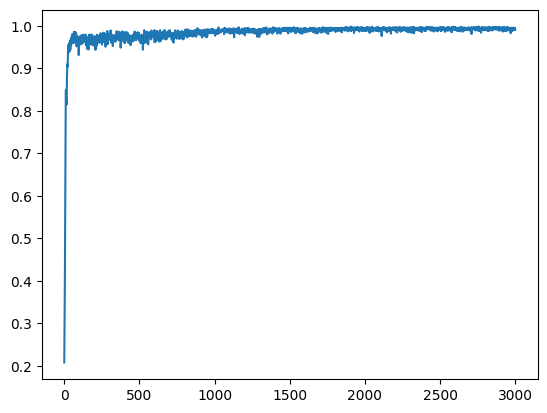

In [37]:
plt.plot(np.array(FoM_history))
# Objective function
def print_order(rho,layer0_thickness):
    order = [11,11]

    sim = torcwa.rcwa(freq=1/lamb0,order=order,L=L,dtype=sim_dtype,device=device)
    sim.add_input_layer(eps=substrate_eps)
    sim.set_incident_angle(inc_ang=inc_ang,azi_ang=azi_ang)
    layer0_eps = rho*silicon_eps + (1.-rho)
    sim.add_layer(thickness=layer0_thickness,eps=layer0_eps)
    sim.solve_global_smatrix()
    
    t11xx = sim.S_parameters(orders=[-1,-1],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t11yy = sim.S_parameters(orders=[-1,-1],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t11xy = sim.S_parameters(orders=[-1,-1],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t11yx = sim.S_parameters(orders=[-1,-1],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T11_sum = torch.abs(t11xx)**2 + torch.abs(t11yy)**2 + torch.abs(t11xy)**2 + torch.abs(t11yx)**2

    t12xx = sim.S_parameters(orders=[-1,0],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t12yy = sim.S_parameters(orders=[-1,0],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t12xy = sim.S_parameters(orders=[-1,0],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t12yx = sim.S_parameters(orders=[-1,0],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T12_sum = torch.abs(t12xx)**2 + torch.abs(t12yy)**2 + torch.abs(t12xy)**2 + torch.abs(t12yx)**2

    t13xx = sim.S_parameters(orders=[-1,1],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t13yy = sim.S_parameters(orders=[-1,1],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t13xy = sim.S_parameters(orders=[-1,1],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t13yx = sim.S_parameters(orders=[-1,1],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T13_sum = torch.abs(t13xx)**2 + torch.abs(t13yy)**2 + torch.abs(t13xy)**2 + torch.abs(t13yx)**2

    t21xx = sim.S_parameters(orders=[0,-1],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t21yy = sim.S_parameters(orders=[0,-1],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t21xy = sim.S_parameters(orders=[0,-1],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t21yx = sim.S_parameters(orders=[0,-1],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T21_sum = torch.abs(t21xx)**2 + torch.abs(t21yy)**2 + torch.abs(t21xy)**2 + torch.abs(t21yx)**2
    
    t22xx = sim.S_parameters(orders=[0,0],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t22yy = sim.S_parameters(orders=[0,0],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t22xy = sim.S_parameters(orders=[0,0],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t22yx = sim.S_parameters(orders=[0,0],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T22_sum = torch.abs(t22xx)**2 + torch.abs(t22yy)**2 + torch.abs(t22xy)**2 + torch.abs(t22yx)**2

    t23xx = sim.S_parameters(orders=[0,1],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t23yy = sim.S_parameters(orders=[0,1],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t23xy = sim.S_parameters(orders=[0,1],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t23yx = sim.S_parameters(orders=[0,1],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T23_sum = torch.abs(t23xx)**2 + torch.abs(t23yy)**2 + torch.abs(t23xy)**2 + torch.abs(t23yx)**2

    t31xx = sim.S_parameters(orders=[1,-1],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t31yy = sim.S_parameters(orders=[1,-1],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t31xy = sim.S_parameters(orders=[1,-1],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t31yx = sim.S_parameters(orders=[1,-1],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T31_sum = torch.abs(t31xx)**2 + torch.abs(t31yy)**2 + torch.abs(t31xy)**2 + torch.abs(t31yx)**2

    t32xx = sim.S_parameters(orders=[1,0],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t32yy = sim.S_parameters(orders=[1,0],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t32xy = sim.S_parameters(orders=[1,0],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t32yx = sim.S_parameters(orders=[1,0],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T32_sum = torch.abs(t32xx)**2 + torch.abs(t32yy)**2 + torch.abs(t32xy)**2 + torch.abs(t32yx)**2

    t33xx = sim.S_parameters(orders=[1,1],direction='forward',port='transmission',polarization='xx',ref_order=[0,0])
    t33yy = sim.S_parameters(orders=[1,1],direction='forward',port='transmission',polarization='yy',ref_order=[0,0])
    t33xy = sim.S_parameters(orders=[1,1],direction='forward',port='transmission',polarization='xy',ref_order=[0,0])
    t33yx = sim.S_parameters(orders=[1,1],direction='forward',port='transmission',polarization='yx',ref_order=[0,0])

    T33_sum = torch.abs(t33xx)**2 + torch.abs(t33yy)**2 + torch.abs(t33xy)**2 + torch.abs(t33yx)**2
    #EFF = T11_sum + T12_sum + T13_sum + T21_sum + T22_sum + T23_sum + T31_sum + T32_sum + T33_sum
    # Concatenate the tensors along a specific dimension, e.g., dimension 0
    concatenated_tensors = torch.cat((T11_sum, T12_sum, T13_sum, T21_sum, T22_sum, T23_sum, T31_sum, T32_sum, T33_sum), dim=0)
    print(concatenated_tensors)
    # Calculate the minimum and maximum of the concatenated tensor
    #min_val = torch.min(concatenated_tensors)
    #max_val = torch.max(concatenated_tensors)

    # Compute the desired value
    #UNIF = min_val / max_val

    # Assuming EFF and UNIF are already defined
    #final_FOM = UNIF

0.9686158
THK = 235.0
tensor([0.1276, 0.1255, 0.1282, 0.1262, 0.1296, 0.1261, 0.1277, 0.1263, 0.1276],
       device='cuda:0')


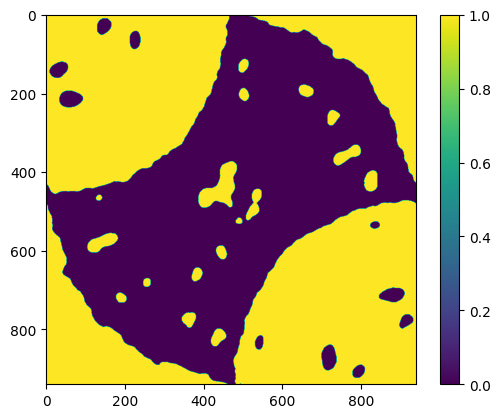

In [52]:
# Export data
filename = 'DOE3x3_data.mat'
#ex6_data = {'rho_history':rho_history,'FoM_history':FoM_history}
#scipy.io.savemat(filename,ex6_data)
rho2 = rho.detach()
rho2[rho2>0.5] = 1
rho2[rho2<0.5] = 0
print(objective_function(rho2).cpu().numpy())
# Plot
print(f'THK = {layer0_thickness}')
print_order(rho2,layer0_thickness)
plt.imshow(rho2.cpu().numpy())
plt.colorbar()

In [39]:
# Field calculation
z = torch.linspace(-500,1500,501,device=device)
z_axis = z.cpu()

rho_fft = torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(rho)))
rho_bar = torch.real(torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(rho_fft*g_fft))))
rho_tilda = 1/2 + torch.tanh(2*beta[-1]*rho.detach()-beta[-1])/(2*np.math.tanh(beta[-1]))

order = [15,8]

sim = torcwa.rcwa(freq=1/lamb0,order=order,L=L,dtype=sim_dtype,device=device)
sim.add_input_layer(eps=substrate_eps)
sim.set_incident_angle(inc_ang=inc_ang,azi_ang=azi_ang)
layer0_eps = rho_tilda*silicon_eps + (1.-rho_tilda)
sim.add_layer(thickness=layer0_thickness,eps=layer0_eps)
sim.solve_global_smatrix()

C:\Users\CYY\AppData\Local\Temp\ipykernel_8372\3737282571.py:7: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  rho_tilda = 1/2 + torch.tanh(2*beta[-1]*rho.detach()-beta[-1])/(2*np.math.tanh(beta[-1]))


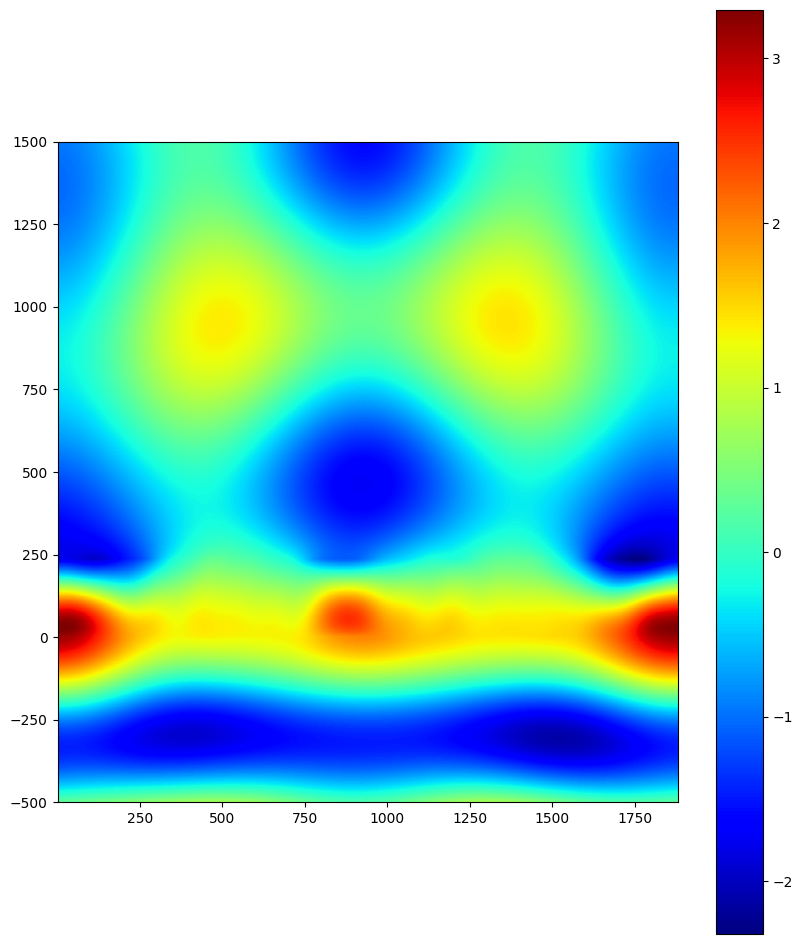

In [40]:
# View XZ-plane fields and export for x-pol input
sim.source_planewave(amplitude=[1.,0.],direction='forward')
[Ex, Ey, Ez], [Hx, Hy, Hz] = sim.field_xz(torcwa.rcwa_geo.x,z,L[1]/2)
Enorm = torch.sqrt(torch.abs(Ex)**2 + torch.abs(Ey)**2 + torch.abs(Ez)**2)
Hnorm = torch.sqrt(torch.abs(Hx)**2 + torch.abs(Hy)**2 + torch.abs(Hz)**2)

plt.figure(figsize=(10,12))
plt.imshow(torch.transpose(torch.real(Hy),-2,-1).cpu(),cmap='jet',origin='lower',extent=[x_axis[0],x_axis[-1],z_axis[0],z_axis[-1]])
plt.colorbar()

ex6_Xpol_data = {'x_axis':x_axis.numpy(),'y_axis':y_axis.numpy(),'z_axis':z_axis.numpy(),\
    'Ex':Ex.cpu().numpy(),'Ey':Ey.cpu().numpy(),'Ez':Ez.cpu().numpy(),'Enorm':Enorm.cpu().numpy(),\
    'Hx':Hx.cpu().numpy(),'Hy':Hy.cpu().numpy(),'Hz':Hz.cpu().numpy(),'Hnorm':Hnorm.cpu().numpy()}
scipy.io.savemat('DOE3x3_data_Xpol_data.mat',ex6_Xpol_data)

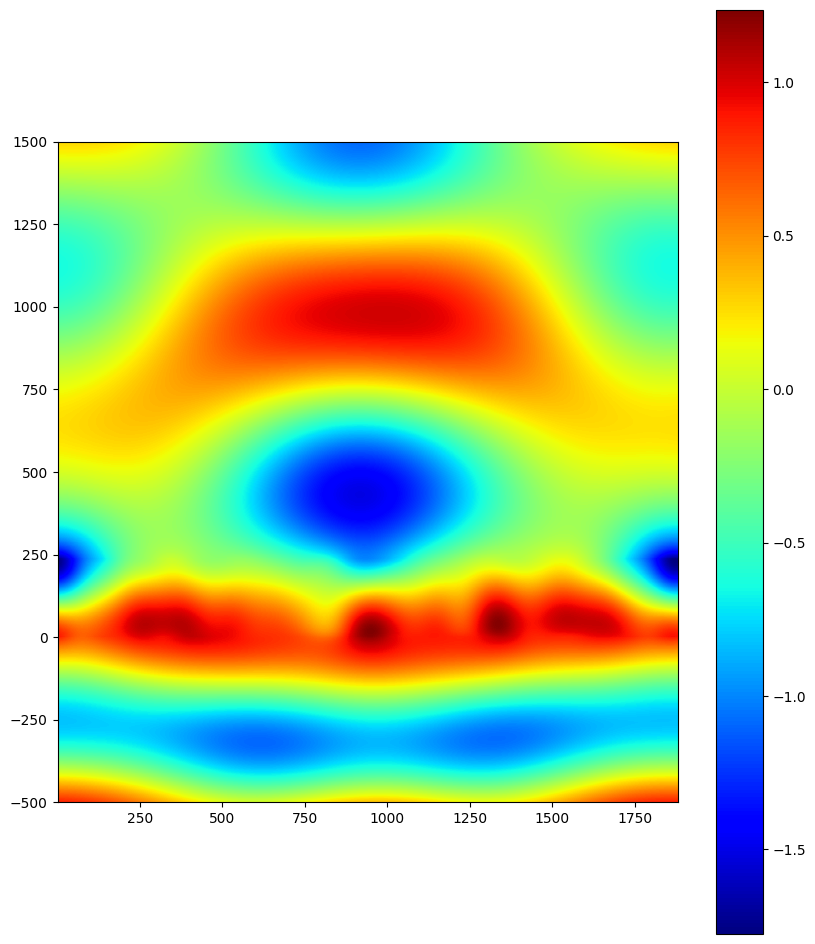

In [41]:
# View XZ-plane fields and export for x-pol input
sim.source_planewave(amplitude=[0.,1.],direction='forward')
[Ex, Ey, Ez], [Hx, Hy, Hz] = sim.field_xz(torcwa.rcwa_geo.x,z,L[1]/2)
Enorm = torch.sqrt(torch.abs(Ex)**2 + torch.abs(Ey)**2 + torch.abs(Ez)**2)
Hnorm = torch.sqrt(torch.abs(Hx)**2 + torch.abs(Hy)**2 + torch.abs(Hz)**2)

plt.figure(figsize=(10,12))
plt.imshow(torch.transpose(torch.real(Ey),-2,-1).cpu(),cmap='jet',origin='lower',extent=[x_axis[0],x_axis[-1],z_axis[0],z_axis[-1]])
plt.colorbar()

ex6_Ypol_data = {'x_axis':x_axis.numpy(),'y_axis':y_axis.numpy(),'z_axis':z_axis.numpy(),\
    'Ex':Ex.cpu().numpy(),'Ey':Ey.cpu().numpy(),'Ez':Ez.cpu().numpy(),'Enorm':Enorm.cpu().numpy(),\
    'Hx':Hx.cpu().numpy(),'Hy':Hy.cpu().numpy(),'Hz':Hz.cpu().numpy(),'Hnorm':Hnorm.cpu().numpy()}
scipy.io.savemat('DOE3x3_data_Ypol_data.mat',ex6_Ypol_data)